# 1. 复现与可视化

## 总的加载

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import cv2
import numpy as np
from notebook.utils import setup_sam_3d_body
from tools.vis_utils import visualize_sample_together

# Set up the estimator
estimator = setup_sam_3d_body(hf_repo_id="facebook/sam-3d-body-dinov3",
                              detector_name="vitdet",
                              detector_path="./checkpoints/detectron2/ViTDet/COCO/cascade_mask_rcnn_vitdet_h/f328730692",
                              segmentor_name="sam3", 
                              segmentor_path="./checkpoints/sam3/sam3.pt", 
                              fov_path="./checkpoints/moge-2-vitl-normal/model.pt", 
                              checkpoint_path="./checkpoints/sam-3d-body-dinov3/model.ckpt", 
                              mhr_path="./checkpoints/sam-3d-body-dinov3/assets/mhr_model.pt")

/home/guest/wmj/Projects/sam-3d-body/sam_3d_body/models/heads/mhr_head.py:33: UserWarning: Momentum is not enabled
  warnings.warn("Momentum is not enabled")


Loading SAM 3D Body model from ./checkpoints/sam-3d-body-dinov3/model.ckpt...
Loading SAM 3D Body model...


Using cache found in /home/guest/.cache/torch/hub/facebookresearch_dinov3_main
Ignored kwargs: {'drop_path': 0.1}
The model and loaded state dict do not match exactly

missing keys in source state_dict: backbone.encoder.mask_token, head_pose.hand_pose_comps_ori, head_pose.mhr.face_expressions_model.shape_vectors, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.0.sparse_indices, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.0.sparse_weight, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.2.weight, head_pose.mhr.character_torch.skeleton.joint_translation_offsets, head_pose.mhr.character_torch.skeleton.joint_prerotations, head_pose.mhr.character_torch.skeleton.pmi, head_pose.mhr.character_torch.skeleton.joint_parents, head_pose.mhr.character_torch.mesh.rest_vertices, head_pose.mhr.character_torch.mesh.faces, head_pose.mhr.character_torch.mesh.texcoords, head_pose.mhr.character_torch.mesh.texcoord_faces, head_pose.mhr.character_torch.parameter_transform.paramet

Loading human detector from ('./checkpoints/detectron2/ViTDet/COCO/cascade_mask_rcnn_vitdet_h/f328730692', 'vitdet')...
########### Using human detector: ViTDet...


/data1/miniconda3/envs/Sam3dBody_env/lib/python3.11/site-packages/detectron2/config/lazy.py:167: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return old_import(name, globals, locals, fromlist=fromlist, level=level)
/data1/miniconda3/envs/Sam3dBody_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading human segmentor from ./checkpoints/sam3/sam3.pt...
########### Using human segmentor: SAM3...
Loading FOV estimator from ('./checkpoints/moge-2-vitl-normal/model.pt', 'moge2')...
########### Using fov estimator: MoGe2...
Setup complete!
  Human detector: ✓
  Human segmentor: ✓
  FOV estimator: ✓


## 使用检测器

In [2]:
# Load and process image
img_bgr = cv2.imread("images/frame_003681.png")
outputs = estimator.process_one_image(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

# vis outputs information
print(len(outputs))
print("---------------------------------------------------------------------------------------")
for k, v in outputs[0].items():
    print(
        f"key: {k:20s} | "
        f"type: {type(v)} | "
        f"shape: {getattr(v, 'shape', None)} | "
        f"dtype: {getattr(v, 'dtype', None)} | "
        f"device: {getattr(v, 'device', None)}"
    )


####### Please make sure the input image is in RGB format
Running object detector...


/data1/miniconda3/envs/Sam3dBody_env/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Found boxes: [[ 353.83884  187.86893  498.25558  498.8422 ]
 [ 821.8005   155.64801 1099.2296   419.66248]
 [1087.2499   205.06586 1116.4172   283.90375]
 [1103.9132   208.45335 1279.7799   574.1892 ]]
4
---------------------------------------------------------------------------------------
key: bbox                 | type: <class 'numpy.ndarray'> | shape: (4,) | dtype: float32 | device: None
key: focal_length         | type: <class 'numpy.float32'> | shape: () | dtype: float32 | device: None
key: pred_keypoints_3d    | type: <class 'numpy.ndarray'> | shape: (70, 3) | dtype: float32 | device: None
key: pred_keypoints_2d    | type: <class 'numpy.ndarray'> | shape: (70, 2) | dtype: float32 | device: None
key: pred_vertices        | type: <class 'numpy.ndarray'> | shape: (18439, 3) | dtype: float32 | device: None
key: pred_cam_t           | type: <class 'numpy.ndarray'> | shape: (3,) | dtype: float32 | device: None
key: pred_pose_raw        | type: <class 'numpy.ndarray'> | shape: (266,) 

### Model Parameters

### Identity Parameters (`identity_coeffs`)
- **Shape**: `[batch_size, 45]`
- **Description**: The first 20 control body shape identity, second 20 control head, and the last 5 for hands.
- **Typical Range**: -3 to +3 (zero-mean, unit variance)

### Model Parameters (`model_parameters`)
- **Shape**: `[batch_size, 204]`
- **Description**: Joint angles and scalings

### Expression Parameters (`face_expr_coeffs`)
- **Shape**: `[batch_size, 72]`
- **Description**: Facial expression blendshape weights
- **Typical Range**: -1 to +1

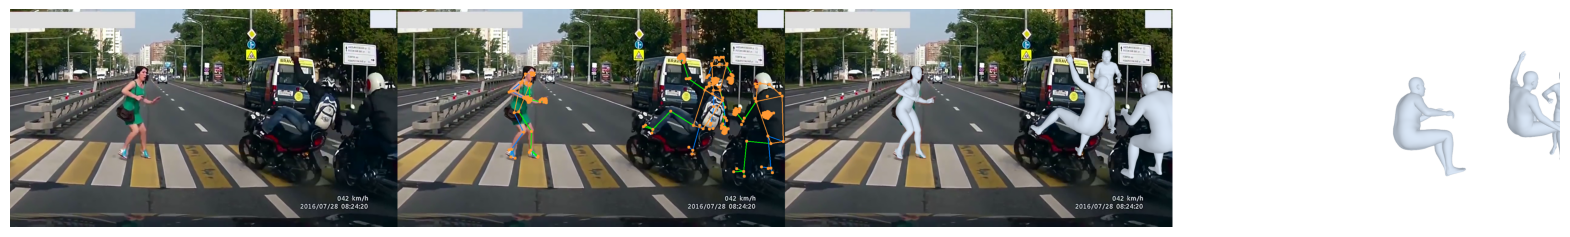

In [3]:
# # Visualize and save results
rend_img = visualize_sample_together(img_bgr, outputs, estimator.faces)
# cv2.imwrite("output.jpg", rend_img.astype(np.uint8))

import cv2
import matplotlib.pyplot as plt
show_img = cv2.cvtColor(rend_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,8))
plt.imshow(show_img)
plt.axis("off")
plt.show()


## 使用BBox

In [4]:
# load PVCP2 label file
import os
import json

pvcp_path = "/data1/wmj/PVCP/"
pvcp_frame = os.path.join(pvcp_path, 'frame')
pvcp_label = os.path.join(pvcp_path, 'annotation', 'dataset_pose.json')

with open(pvcp_label, 'r') as f:
    pvcp_data = json.load(f)
print(len(pvcp_data), type(pvcp_data))

def lxlywh_to_xyxy(bbox):
    """
    Convert bbox from (lx, ly, w, h) to (x1, y1, x2, y2)

    Args:
        bbox: list / tuple / np.ndarray with 4 elements

    Returns:
        np.ndarray of shape (4,) -> [x1, y1, x2, y2]
    """
    lx, ly, w, h = bbox
    x1 = lx
    y1 = ly
    x2 = lx + w
    y2 = ly + h
    return np.array([x1, y1, x2, y2], dtype=np.float32)

42511 <class 'dict'>


####### Please make sure the input image is in RGB format
1 <class 'list'>
---------------------------------------------------------------------------------------
key: bbox                 | type: <class 'numpy.ndarray'> | shape: (4,) | dtype: float32 | device: None
key: focal_length         | type: <class 'numpy.float32'> | shape: () | dtype: float32 | device: None
key: pred_keypoints_3d    | type: <class 'numpy.ndarray'> | shape: (70, 3) | dtype: float32 | device: None
key: pred_keypoints_2d    | type: <class 'numpy.ndarray'> | shape: (70, 2) | dtype: float32 | device: None
key: pred_vertices        | type: <class 'numpy.ndarray'> | shape: (18439, 3) | dtype: float32 | device: None
key: pred_cam_t           | type: <class 'numpy.ndarray'> | shape: (3,) | dtype: float32 | device: None
key: pred_pose_raw        | type: <class 'numpy.ndarray'> | shape: (266,) | dtype: float32 | device: None
key: global_rot           | type: <class 'numpy.ndarray'> | shape: (3,) | dtype: float32 | device

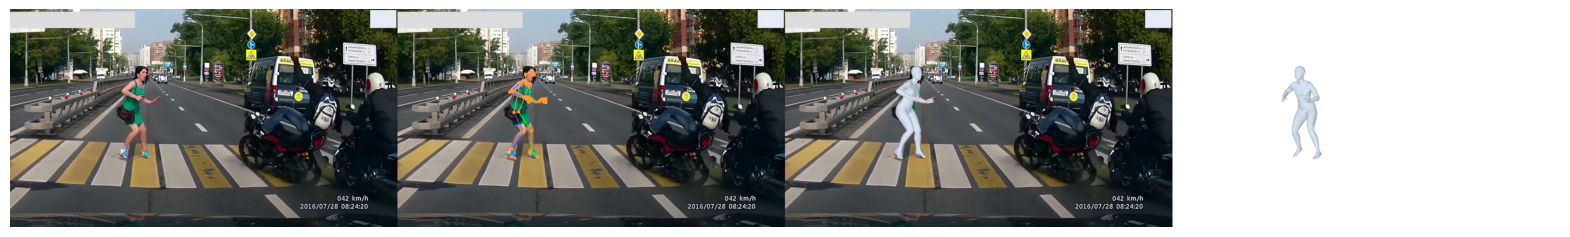

In [5]:
import cv2
import matplotlib.pyplot as plt

bbox = pvcp_data["frame_003681.png"]['bbox']  # [lx, ly, w, h]
frame_path = os.path.join(pvcp_frame, "frame_003681.png")

img_bgr = cv2.imread(frame_path)
outputs = estimator.process_one_image(img=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), 
                                      bboxes=lxlywh_to_xyxy(bbox))
print(len(outputs), type(outputs))
print("---------------------------------------------------------------------------------------")
for k, v in outputs[0].items():
    print(
        f"key: {k:20s} | "
        f"type: {type(v)} | "
        f"shape: {getattr(v, 'shape', None)} | "
        f"dtype: {getattr(v, 'dtype', None)} | "
        f"device: {getattr(v, 'device', None)}"
    )
print("# [lx, ly,  w,  h]", bbox)
print("# [x1, y1, x2, y2]", outputs[0]['bbox'])

# Visualize and save results

rend_img = visualize_sample_together(img_bgr, outputs, estimator.faces)
show_img = cv2.cvtColor(rend_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,8))
plt.imshow(show_img)
plt.axis("off")
plt.show()

In [6]:
def to_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif obj is None:
        return None
    elif isinstance(obj, dict):
        return {k: to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_json_serializable(v) for v in obj]
    else:
        return obj
    
json_outputs = to_json_serializable(outputs)

save_path = "outputs.json"
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(json_outputs, f, indent=2)

print("✅ Saved outputs.json to:", save_path)

✅ Saved outputs.json to: outputs.json


In [7]:
data_to_save = {
    "lbs_model_params": np.stack([o["mhr_model_params"] for o in outputs]),
    "identity_coeffs":  np.stack([o["shape_params"] for o in outputs]),
    "face_expr_coeffs": np.stack([o["expr_params"] for o in outputs]),
}

save_path = "output.npy"
np.save(save_path, data_to_save)
print("✅ Saved outputs.npy to:", save_path)

✅ Saved outputs.npy to: output.npy


In [ ]:
import numpy as np
import os

def inspect_npy(npy_path, show_values=False, max_items=3, head_n=5):
    """
    Inspect contents of a .npy file (supports dict saved via np.save).
    
    Args:
        npy_path: path to .npy
        show_values: whether to print a small preview of values
        max_items: max number of dict items to preview values for
        head_n: how many elements to show in preview
    """
    assert os.path.exists(npy_path), f"File not found: {npy_path}"
    obj = np.load(npy_path, allow_pickle=True)

    print("========================================")
    print("File:", npy_path)
    print("Loaded type:", type(obj))
    print("========================================")

    # Case 1: saved a dict (common when np.save(path, dict))
    if isinstance(obj, np.ndarray) and obj.dtype == object:
        try:
            data = obj.item()
        except Exception as e:
            print("This looks like an object array but cannot .item() into dict.")
            print("Error:", e)
            print("Array shape:", obj.shape, "dtype:", obj.dtype)
            return

        print("Detected: dict saved in npy")
        print("Keys:", list(data.keys()))
        print("----------------------------------------")
        for k, v in data.items():
            if isinstance(v, np.ndarray):
                print(f"{k:20s} | type=np.ndarray | shape={v.shape} | dtype={v.dtype} | "
                      f"min={np.min(v):.6g} max={np.max(v):.6g}")
            else:
                print(f"{k:20s} | type={type(v)} | value={v}")

        if show_values:
            print("\n========== Value preview ==========")
            for i, (k, v) in enumerate(data.items()):
                if i >= max_items:
                    break
                print(f"\n[{k}]")
                if isinstance(v, np.ndarray):
                    flat = v.reshape(-1)
                    print("head:", flat[:head_n])
                else:
                    print(v)

    # Case 2: saved a plain ndarray
    elif isinstance(obj, np.ndarray):
        arr = obj
        print("Detected: plain numpy array saved in npy")
        print("shape:", arr.shape)
        print("dtype:", arr.dtype)
        print("min:", np.min(arr), "max:", np.max(arr))
        if show_values:
            print("head:", arr.reshape(-1)[:head_n])

    else:
        # Very rare, but handle anyway
        print("Unknown loaded object type.")
        print(obj)

# -------------------------
# Usage:
# -------------------------
npy_path = "output.npy"  # 改成你的文件路径
inspect_npy(npy_path, show_values=True)


File: output.npy
Loaded type: <class 'numpy.ndarray'>
Detected: dict saved in npy
Keys: ['lbs_model_params', 'identity_coeffs', 'face_expr_coeffs']
----------------------------------------
lbs_model_params     | type=np.ndarray | shape=(1, 204) | dtype=float32 | min=-0.862227 max=1.20611
identity_coeffs      | type=np.ndarray | shape=(1, 45) | dtype=float32 | min=-1.5128 max=1.33822
face_expr_coeffs     | type=np.ndarray | shape=(1, 72) | dtype=float32 | min=-0 max=-0

========== Value preview ==========

[lbs_model_params]
head: [0.         0.         0.         0.32638773 1.1355292 ]

[identity_coeffs]
head: [-1.4814717   1.0395473  -0.98888355  0.3880768   0.01392173]

[face_expr_coeffs]
head: [ 0. -0. -0. -0. -0.]


: 